In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.7 MB/s eta 0:00:0000:0100:01


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.model_selection import GridSearchCV

In [4]:
df=pd.read_csv('/kaggle/input/movie-data/movie_data_full_final.csv')


In [5]:
df.head()

,Title,Year,Runtime (Minutes),Genre,IMDB,Metascore,Description,Director,Stars,Votes,Gross ($)
0,Star Wars: Episode VII - The Force Awakens,2015,138,"Action, Adventure, Sci-Fi",7.8,80.0,"As a new threat to the galaxy rises, Rey, a de...",J.J. Abrams,"Daisy Ridley,John Boyega,Oscar Isaac,Domhnall ...",954497,936662225
1,Avengers: Endgame,2019,181,"Action, Adventure, Drama",8.4,78.0,After the devastating events of Avengers: Infi...,"Anthony Russo, Joe Russo","Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...",1207434,858373000
2,Spider-Man: No Way Home,2021,148,"Action, Adventure, Fantasy",8.2,71.0,"With Spider-Man's identity now revealed, Peter...",Jon Watts,"Tom Holland,Zendaya,Benedict Cumberbatch,Jacob...",824858,804747988
3,Avatar,2009,162,"Action, Adventure, Fantasy",7.9,83.0,A paraplegic Marine dispatched to the moon Pan...,James Cameron,"Sam Worthington,Zoe Saldana,Sigourney Weaver,M...",1358149,760507625
4,Top Gun: Maverick,2022,130,"Action, Drama",8.3,78.0,"After thirty years, Maverick is still pushing ...",Joseph Kosinski,"Tom Cruise,Jennifer Connelly,Miles Teller,Val ...",623686,718732821


In [6]:
df['Gross ($)']=round(df['Gross ($)']/1000000)

In [7]:
df.rename(columns= {'Gross ($)': 'Gross ($ Millions)'}, inplace=True)

In [8]:
unique_genres = set()
for genres in df['Genre']:
    genre_list = genres.split(', ')
    unique_genres.update(genre_list)

def create_genre_columns(row, genre):
    if genre in row['Genre']:
        return 1
    else:
        return 0

# Applying function to create binary columns for each genre
for genre in unique_genres:
    df[genre] = df.apply(lambda row: create_genre_columns(row, genre), axis=1)

df.drop('Genre', axis=1, inplace=True)
df.head()


,Title,Year,Runtime (Minutes),IMDB,Metascore,Description,Director,Stars,Votes,Gross ($ Millions),...,Western,History,Mystery,Action,Biography,War,Music,Crime,Animation,Thriller
0,Star Wars: Episode VII - The Force Awakens,2015,138,7.8,80.0,"As a new threat to the galaxy rises, Rey, a de...",J.J. Abrams,"Daisy Ridley,John Boyega,Oscar Isaac,Domhnall ...",954497,937.0,...,0,0,0,1,0,0,0,0,0,0
1,Avengers: Endgame,2019,181,8.4,78.0,After the devastating events of Avengers: Infi...,"Anthony Russo, Joe Russo","Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chr...",1207434,858.0,...,0,0,0,1,0,0,0,0,0,0
2,Spider-Man: No Way Home,2021,148,8.2,71.0,"With Spider-Man's identity now revealed, Peter...",Jon Watts,"Tom Holland,Zendaya,Benedict Cumberbatch,Jacob...",824858,805.0,...,0,0,0,1,0,0,0,0,0,0
3,Avatar,2009,162,7.9,83.0,A paraplegic Marine dispatched to the moon Pan...,James Cameron,"Sam Worthington,Zoe Saldana,Sigourney Weaver,M...",1358149,761.0,...,0,0,0,1,0,0,0,0,0,0
4,Top Gun: Maverick,2022,130,8.3,78.0,"After thirty years, Maverick is still pushing ...",Joseph Kosinski,"Tom Cruise,Jennifer Connelly,Miles Teller,Val ...",623686,719.0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()
#label_encoder = LabelEncoder()
#df_encoded['Genre'] = label_encoder.fit_transform(df_encoded['Genre'])

In [10]:
#Calculating Star importance to take care of categorical star names
from collections import Counter
star_counts = Counter(df_encoded['Stars'].str.split(',').sum())
star_revenue={}
for index,row in df_encoded.iterrows():
    stars=row['Stars'].split(',')
    gross=row['Gross ($ Millions)']
    gross_per_star=gross/len(stars)
    for star in stars: 
        if star in star_revenue:
            star_revenue[star]+=gross_per_star
        else:
            star_revenue[star]=gross_per_star
min_value=min(star_revenue.values())
max_value=max(star_revenue.values())
for key,values in star_revenue.items():
    star_revenue[key]=(values-min_value)/(max_value-min_value)
total_importance={}
for star in star_revenue:
    total_importance[star]=star_counts[star]*star_revenue[star]
def calculate_total(keys):
    return sum(total_importance[key] for key in keys)

df_encoded['Total Star Importance']=df_encoded['Stars'].str.split(',').apply(calculate_total)

In [11]:
#Calculating Director importance to take care of categorical director names
from collections import Counter
director_counts = Counter(df_encoded['Director'].str.split(', ').sum())
director_revenue = {}
for index, row in df_encoded.iterrows():
    directors = row['Director'].split(', ')
    gross = row['Gross ($ Millions)']
    share_per_director = gross / len(directors)
    for director in directors:
        if director in director_revenue:
            director_revenue[director] += share_per_director
        else:
            director_revenue[director] = share_per_director
min_value=min(director_revenue.values())
max_value=max(director_revenue.values())
for key,values in director_revenue.items():
    director_revenue[key]=(values-min_value)/(max_value-min_value)
total_director_importance={}
for director in director_revenue:
    total_director_importance[director]=director_counts[director]*director_revenue[director]
def calculate_director_importance(keys):
    return sum(total_director_importance[key] for key in keys)
df_encoded['Total Director Importance']=df_encoded['Director'].str.split(', ').apply(calculate_director_importance)

In [12]:
df_encoded = df_encoded.sample(frac=1, random_state=33)
df_encoded.reset_index(drop=True, inplace=True)
df_encoded.head()

,Title,Year,Runtime (Minutes),IMDB,Metascore,Description,Director,Stars,Votes,Gross ($ Millions),...,Mystery,Action,Biography,War,Music,Crime,Animation,Thriller,Total Star Importance,Total Director Importance
0,Nobody's Fool,2018,110,5.0,39.0,A woman is released from prison and reunites w...,Tyler Perry,"Tiffany Haddish,Tika Sumpter,Omari Hardwick,Me...",7935,32.0,...,0,0,0,0,0,0,0,0,1.257143,3.950349
1,Hyde Park on Hudson,2012,94,5.9,55.0,The story of the love affair between FDR and h...,Roger Michell,"Bill Murray,Laura Linney,Olivia Williams,Samue...",12195,6.0,...,0,0,1,0,0,0,0,0,14.652803,0.404300
2,Conquest of the Planet of the Apes,1972,88,6.1,49.0,In a futuristic world that has embraced ape sl...,J. Lee Thompson,"Roddy McDowall,Don Murray,Ricardo Montalban,Na...",34495,10.0,...,0,1,0,0,0,0,0,0,0.253707,0.138092
3,Daylight,1996,114,5.9,47.0,Disaster in a New York tunnel as explosions co...,Rob Cohen,"Sylvester Stallone,Amy Brenneman,Viggo Mortens...",75171,33.0,...,0,1,0,0,0,0,0,0,17.361844,1.565333
4,Bloodsport,1988,92,6.8,29.0,"""Bloodsport"" follows Frank Dux, an American ma...",Newt Arnold,"Jean-Claude Van Damme,Donald Gibb,Leah Ayres,N...",90324,12.0,...,0,1,1,0,0,0,0,0,1.301989,0.002660


# Correlation Matrix for Movie Data

This correlation matrix provides insights into the relationships between various movie-related attributes:

- **Year**: There is a slight positive correlation (0.107267) between the release year of a movie and its gross revenue, indicating a general increase in revenue over the years. However, this correlation is relatively weak.

- **Runtime (Minutes)**: There is a positive correlation (0.240738) between the duration of a movie and its gross revenue. Longer movies tend to have higher gross earnings, possibly due to premium pricing for longer films.

- **IMDB Score**: A moderate positive correlation (0.172508) exists between a movie's IMDB score and its gross revenue. Well-rated movies tend to earn more, suggesting that audience satisfaction influences earnings.

- **Metascore**: Similarly, there is slight a positive correlation (0.094782) between a movie's Metascore and its gross revenue.

- **Votes**: A strong positive correlation (0.624212) is observed between the number of votes a movie receives and its gross revenue. More popular movies tend to earn more, emphasizing the role of audience engagement in financial success.

- **Total Star Importance**: There is a notable positive correlation (0.350596) between the total importance of stars in a movie and its gross revenue. Movies featuring influential stars often perform better at the box office, highlighting the star power's financial impact.

- **Total Director Importance**: A positive correlation (0.241798) exists between the total importance of the director and a movie's gross revenue. Renowned directors often contribute to a movie's success, showcasing the significance of experienced filmmakers.

- **Genre Factors**: While not highlighted in positive correlations, it's essential to consider genre factors. For instance, genres like "Adventure", "Action" and "Animation" have a relatively strong positive correlation with "Gross ($)". This suggests that movies in these genres tend to perform well financially. Conversely, genres like "Thriller" and "Horror" show weaker correlations with earnings.


These insights indicate that factors such as movie ratings, runtime, popularity (measured by votes), star importance, director importance, and genre can influence a movie's gross revenue. Additionally, the specific genre can significantly impact financial performance. These findings are valuable for understanding the dynamics of the movie industry and can be utilized machine learning prediction models.


Text(0.5, 1.0, 'Correlation Martrix')

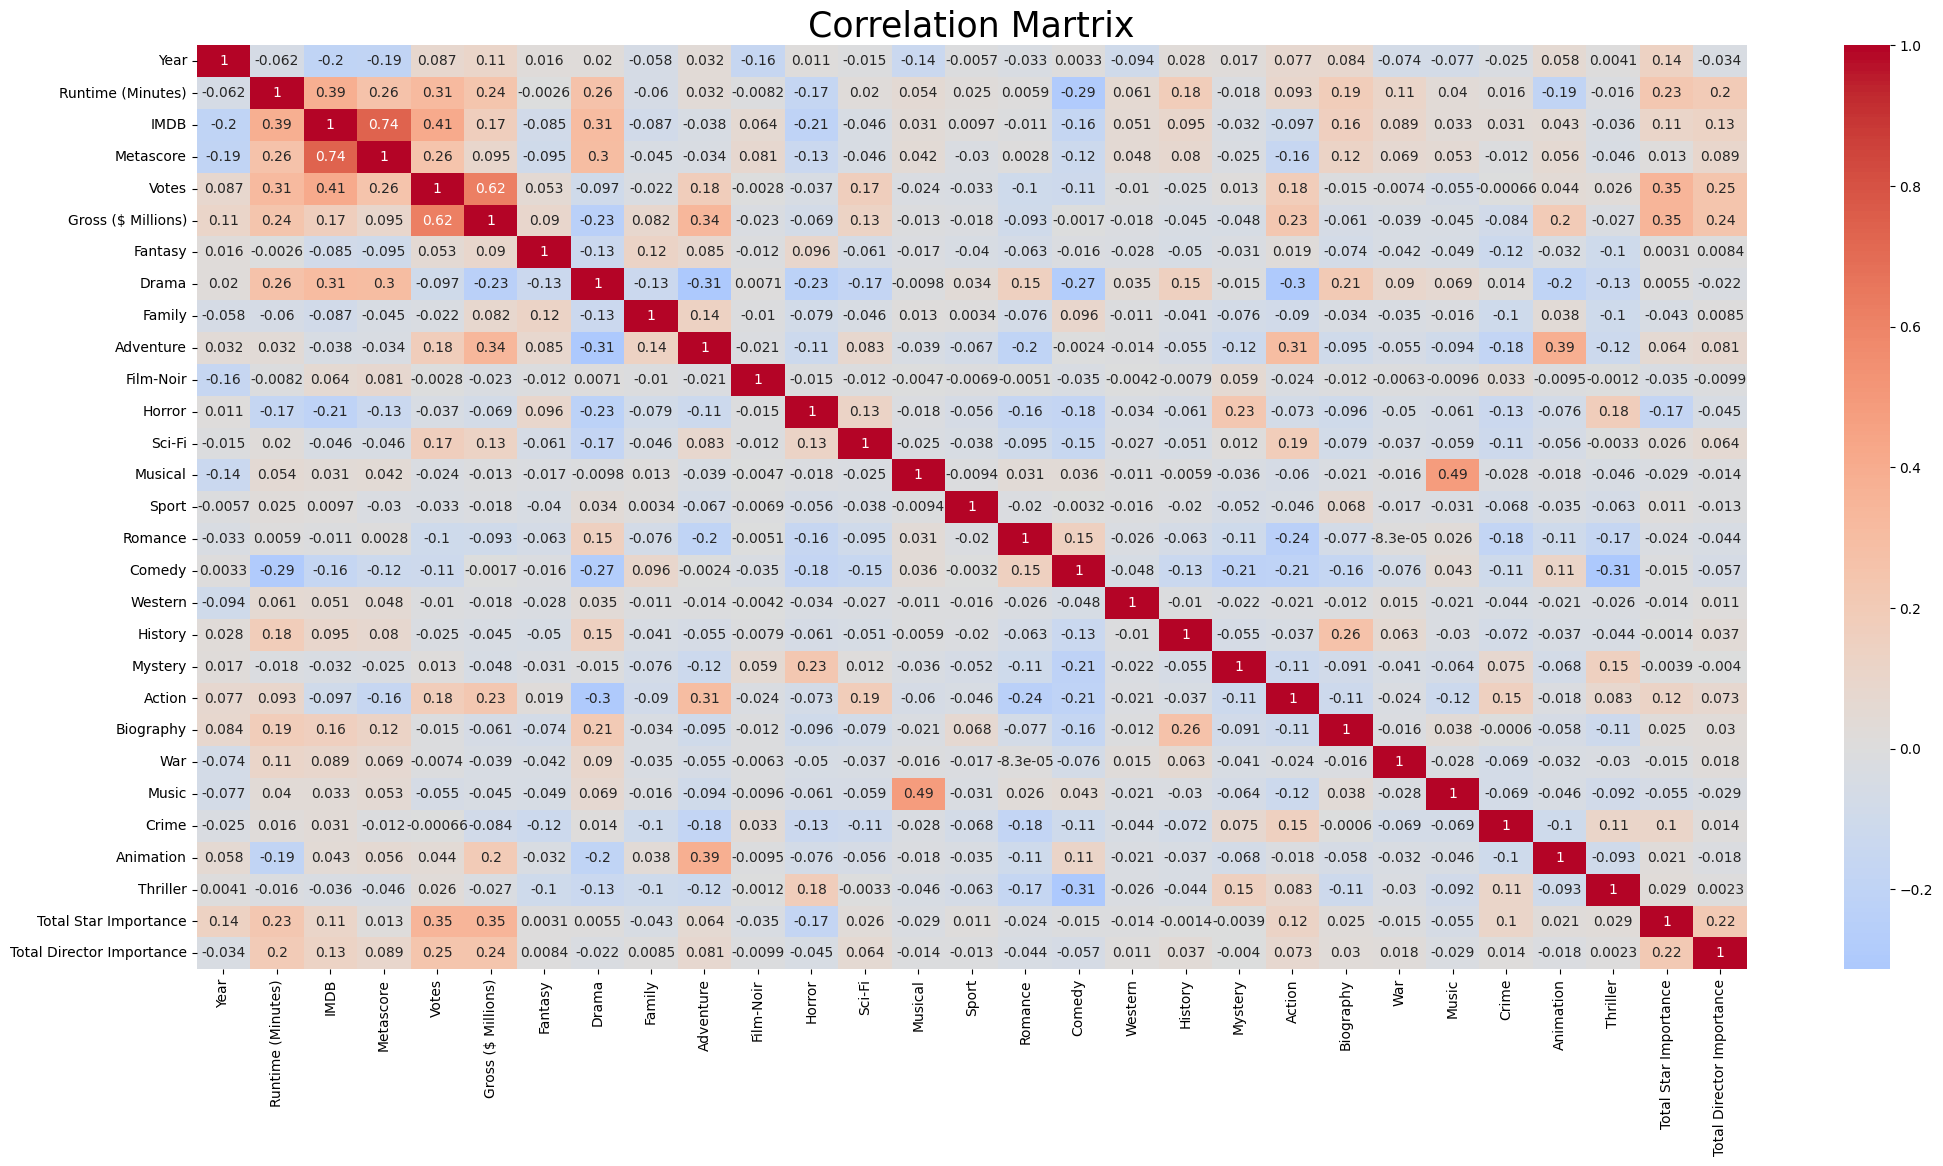

In [13]:
correlation_matrix=df_encoded.corr(numeric_only=True)
fig=plt.figure(figsize=(25,12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, center=0)
plt.title('Correlation Martrix', fontsize=25)

# Box Plot for Movie Gross Revenue Outlier Detection

This box plot graph depicts the distribution of movie gross revenue across different years. The plot is designed to identify outliers and understand the distribution of revenue within each year.

- **X-axis**: Year
- **Y-axis**: Revenue (Millions)

Key Insights:

- The plot spans from 1995 to 2022, covering several decades of movie releases.

- Each box represents a specific year, showing the distribution of gross revenue for movies released in that year.

- Outliers, represented as individual data points beyond the whiskers of the boxes, indicate movies with exceptionally high or low revenue compared to the norm for that year.

- It's evident that there are numerous outliers in the data, suggesting a wide range of revenue outcomes for movies within each year.

- Some years, such as the early 2000s, appear to have a higher concentration of outliers, indicating a greater variance in movie success during those periods.

This plot provides valuable insights into the distribution of movie revenue and highlight the presence of outliers. These insights are important for data analysis and machine learning tasks, such as building predictive models for movie revenue.


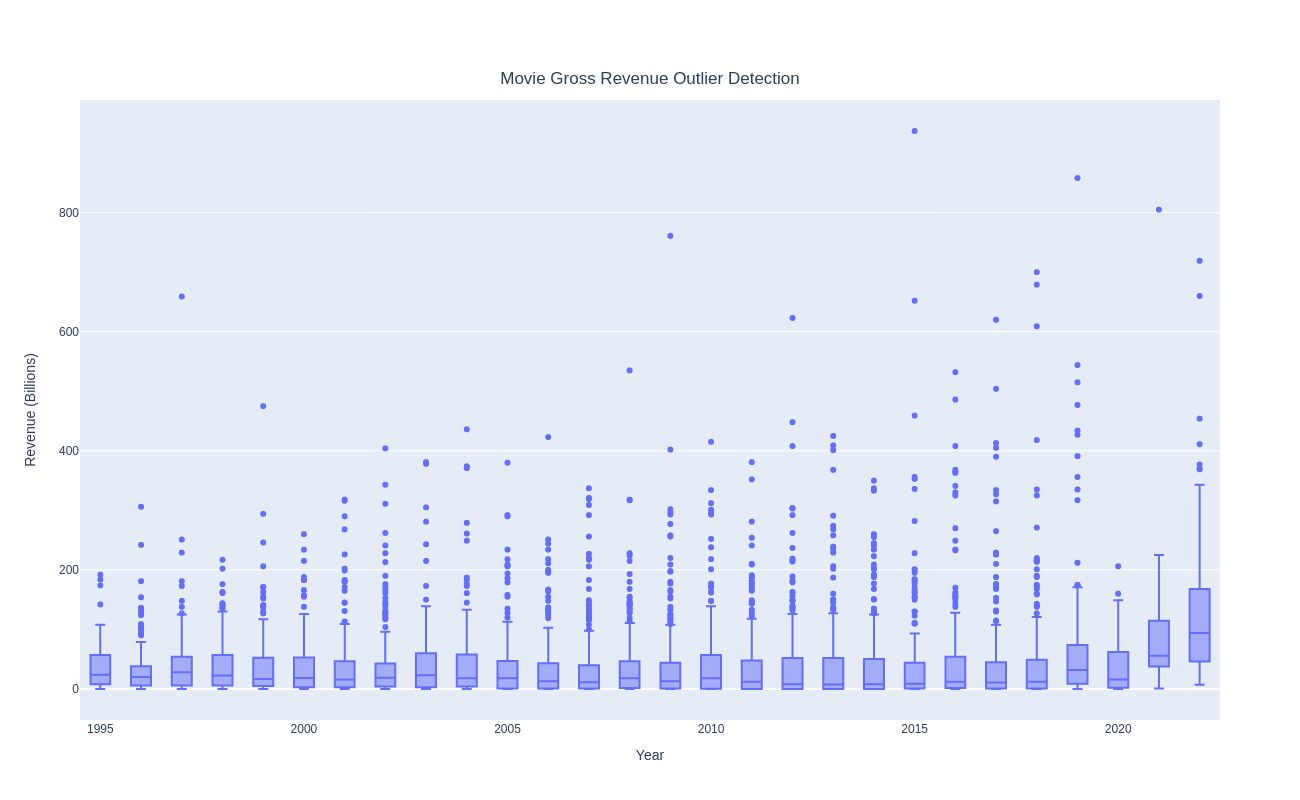

In [14]:
box_data=df.sort_values(by='Year')
box_data=box_data[box_data['Year'] >=1995]
fig= px.box(box_data, x='Year', y='Gross ($ Millions)', title='Movie Gross Revenue Outlier Detection')
fig.update_layout(yaxis_title='Revenue (Billions)',title=dict(x=0.5,y=0.91), width=1300, height=800)
fig.show(renderer='png')

In [15]:
X=df_encoded.drop(['Description', 'Title', 'Stars', 'Director'], axis=1)
X=X[(X['Year'] >= 1995) & (X['Year'] <= 2019)]
X=X[X['Gross ($ Millions)']>=1]
X=X[X['Runtime (Minutes)']<=240]
Y=X['Gross ($ Millions)']
X=X.drop(['Gross ($ Millions)'], axis=1)

X_train, X_test, Y_train, Y_test= train_test_split(X,Y,test_size=0.2,random_state=30)
scaler=StandardScaler()
X_train_transformed=scaler.fit_transform(X_train)
X_test_transformed=scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'SVR': SVR(),
    'AdaBoost': AdaBoostRegressor(),
    'Decision Tree': DecisionTreeRegressor()
} 

model_names = []
mse_scores = []
r2_scores = []
rmse_scores = []
accuracy_scores=[]

for model_name, model in models.items():

    model.fit(X_train_transformed, Y_train)
    Y_pred = model.predict(X_test_transformed)

    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    accuracy=model.score(X_test_transformed, Y_test)*100

    model_names.append(model_name)
    mse_scores.append(mse)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    accuracy_scores.append(accuracy)

results= pd.DataFrame({
    'Model': model_names,
    'MSE': mse_scores,
    'R2 Score': r2_scores,
    'RMSE': rmse_scores,
    'Accuracy':accuracy_scores
})
results.sort_values(by='Accuracy', ascending=False)

,Model,MSE,R2 Score,RMSE,Accuracy
3,Random Forest,971.494527,0.819706,31.168807,81.970606
4,Gradient Boosting,1135.512346,0.789267,33.697364,78.926696
8,Decision Tree,1939.348727,0.640088,44.038037,64.008771
5,K-Nearest Neighbors,2027.377039,0.623751,45.026404,62.375105
1,Ridge,2361.552050,0.561733,48.595803,56.173348
0,Linear Regression,2361.602436,0.561724,48.596321,56.172413
2,Lasso,2375.076940,0.559223,48.734761,55.922348
7,AdaBoost,3985.881528,0.260284,63.133838,26.028375
6,SVR,4250.157947,0.211238,65.193235,21.123825


In [16]:
#Some features were affecting gradient boosting negatively hence dropped
X=df_encoded.drop(['Description', 'Title', 'Stars', 'Director','Musical', 'Metascore', 'Thriller', 'Comedy', 'Sport', 'Total Star Importance','War',
                   'Western','Romance', 'Film-Noir', 'History', 'Music', 'Fantasy', 'Sci-Fi', 'Mystery'], axis=1)
X=X[(X['Year'] >= 1995) & (X['Year'] <= 2019)]
X=X[X['Gross ($ Millions)']>=1]
X=X[X['Runtime (Minutes)']<=240]
Y=X['Gross ($ Millions)']
X=X.drop(['Gross ($ Millions)'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
scaler=StandardScaler()
X_train_transformed_GB=scaler.fit_transform(X_train)
X_test_transformed_GB=scaler.transform(X_test)

#Some features were affecting Random Forest negatively hence dropped
X=df_encoded.drop(['Description', 'Title', 'Stars', 'Director','Sci-Fi', 'Mystery', 'Adventure', 'Music', 'War', 'Film-Noir', 'Musical', 'Sport'], axis=1)
X=X[(X['Year'] >= 1995) & (X['Year'] <= 2019)]
X=X[X['Gross ($ Millions)']>=1]
X=X[X['Runtime (Minutes)']<=240]
Y=X['Gross ($ Millions)']
X=X.drop(['Gross ($ Millions)'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
scaler=StandardScaler()
X_train_transformed_RF=scaler.fit_transform(X_train)
X_test_transformed_RF=scaler.transform(X_test)

In [17]:
from sklearn.model_selection import GridSearchCV

# Creating the top models for hyperparameter tuning
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Defining the parameter grids for each model
param_grid_random_forest = {
    'n_estimators': [100, 150, 200, 250, 275, 300],
    'min_samples_leaf': [1, 2, 3],
    'criterion': ['squared_error', 'friedman_mse', 'poisson']
}

param_grid_gradient_boosting = {
    'n_estimators': [100, 150, 200, 225, 250, 275, 300],
    'learning_rate': [0.09, 0.1, 0.2],
    'max_depth': [3, 4, 5, 7],
    'criterion': ['friedman_mse', 'squared_error'],
    'loss': ['squared_error'],
    'subsample':[0.79, 0.8, 0.9, 1.0]
}

# Creating the grid search for each model
grid_search_random_forest = GridSearchCV(random_forest, param_grid_random_forest, cv=5)
grid_search_gradient_boosting = GridSearchCV(gradient_boosting, param_grid_gradient_boosting, cv=5)

# Fitting the grid search
grid_search_random_forest.fit(X_train_transformed_RF, Y_train)
grid_search_gradient_boosting.fit(X_train_transformed_GB, Y_train)

# Getting the best estimators
best_random_forest = grid_search_random_forest.best_estimator_
best_gradient_boosting = grid_search_gradient_boosting.best_estimator_
print("Best Hyperparameters for Random Forest: ", best_random_forest)
print("Best Hyperparameters for Gradient Boosting: ", best_gradient_boosting)

# Making predictions on the test data using the best estimators
y_pred_random_forest = best_random_forest.predict(X_test_transformed_RF)
y_pred_gradient_boosting = best_gradient_boosting.predict(X_test_transformed_GB)

# Evaluating the models
r2_random_forest = r2_score(Y_test, y_pred_random_forest)
r2_gradient_boosting = r2_score(Y_test, y_pred_gradient_boosting)
print("Random Forest R-squared Score on Test Data:", r2_random_forest)
print("Gradient Boosting R-squared Score on Test Data:", r2_gradient_boosting)


Best Hyperparameters for Random Forest:  RandomForestRegressor(criterion='friedman_mse', min_samples_leaf=2,
                      n_estimators=200, random_state=42)
Best Hyperparameters for Gradient Boosting:  GradientBoostingRegressor(n_estimators=200, random_state=42, subsample=0.79)


In [18]:
# Making predictions on the test data using the best estimators
y_pred_random_forest = best_random_forest.predict(X_test_transformed_RF)
y_pred_gradient_boosting = best_gradient_boosting.predict(X_test_transformed_GB)

# Evaluating the models
r2_random_forest = r2_score(Y_test, y_pred_random_forest)
r2_gradient_boosting = r2_score(Y_test, y_pred_gradient_boosting)
print("Random Forest R-squared Score on Test Data:", r2_random_forest)
print("Gradient Boosting R-squared Score on Test Data:", r2_gradient_boosting)

Random Forest R-squared Score on Test Data: 0.9211877428107518
Gradient Boosting R-squared Score on Test Data: 0.863186287333992


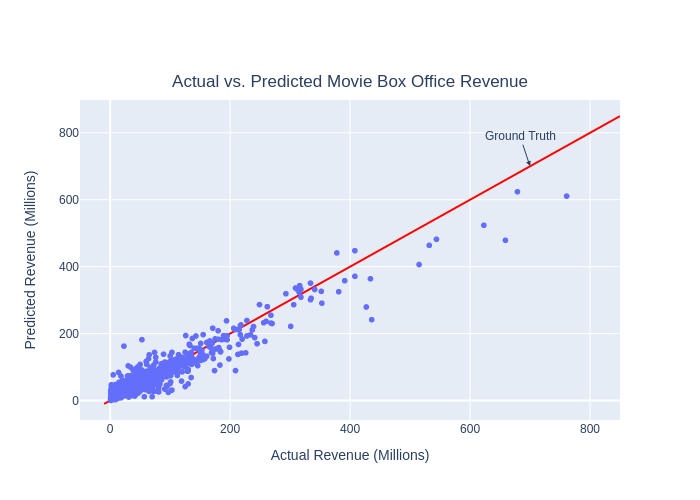

In [19]:
import plotly.express as px
df = pd.DataFrame({'Actual Revenue': Y_test, 'Predicted Revenue': y_pred_random_forest})
fig = px.scatter(df, x='Actual Revenue', y='Predicted Revenue', title='Actual vs. Predicted Movie Box Office Revenue',
                 labels={'Actual Revenue': 'Actual Revenue (Millions)', 'Predicted Revenue': 'Predicted Revenue (Millions)'})
fig.add_trace(px.line(x=[-10, 850], y=[-10, 850]).data[0])
fig.update_traces(line_color='red')
fig.add_annotation(x=700, y=700, text='Ground Truth', showarrow=True, arrowhead=2)
fig.update_layout(title=dict(x=0.5,y=0.85))
fig.show(renderer='png')
